In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Envision'
# data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/GB1'

In [5]:
results_file = os.path.join(data_path, 'results_TEM1_zeroshot.csv')
# results_file = os.path.join(data_path, 'results_GB1_zeroshot.csv')
df_zeroshot = pd.read_csv(results_file)

In [6]:
results_file = os.path.join(data_path, 'results_TEM1_embed.csv')
# results_file = os.path.join(data_path, 'results_GB1_embed.csv')
df_embed = pd.read_csv(results_file)

In [7]:
df_zeroshot.head()

,pos,variant,fitness_raw,fitness_norm,wt_aa,n_mut,seq,fold_id,split_id,pred_ESM650M_masked_marginal,pred_ESM3_masked_marginal,pred_ESMC300M_masked_marginal,pred_ESMC600M_masked_marginal,pred_ESMC300M_confit
0,58,F58N,1.537240,1.142208,F,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1,2,-1.232786,-2.039062,-0.687500,0.750000,-2.8125
1,19,L19W,1.053720,1.094952,L,1,MSIQHFRVALIPFFAAFCWPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2,-3.308943,-3.585938,-3.136719,-3.265625,-2.6250
2,15,A15Y,0.823567,1.072459,A,1,MSIQHFRVALIPFFYAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2,-2.954151,-3.800781,-2.390625,-2.734375,-0.7500
3,182,A182M,0.768011,1.067029,A,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,6,0,-1.501859,-0.421875,-1.750000,-1.632812,-1.0000
4,281,S281F,0.768011,1.067029,S,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,9,2,-2.640135,-3.921875,-1.984375,-2.078125,-1.0000


In [8]:
df_embed.head()

,pos,variant,fitness_raw,fitness_norm,wt_aa,n_mut,seq,fold_id,split_id,pred_OHE_ridge,...,pred_ESMC300M_feat_mean_ridge,pred_ESMC300M_feat_mean_RF,pred_ESMC300M_feat_mean_MLP,pred_ESMC600M_feat_mean_ridge,pred_ESMC600M_feat_mean_RF,pred_ESMC600M_feat_mean_MLP,pred_ESM650M_concat_ridge,pred_ESM3_concat_ridge,pred_ESMC300M_concat_ridge,pred_ESMC600M_concat_ridge
0,58,F58N,1.537240,1.142208,F,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1,2,0.136732,...,-2.263684,0.526760,-2.289371,-2.263681,0.362521,-2.320455,1.289223,1.537537,-0.277069,-0.249252
1,19,L19W,1.053720,1.094952,L,1,MSIQHFRVALIPFFAAFCWPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2,0.536357,...,-2.263635,0.542844,-2.279076,-2.263646,0.627379,-2.307993,0.843422,1.053726,0.535736,0.121071
2,15,A15Y,0.823567,1.072459,A,1,MSIQHFRVALIPFFYAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2,-0.215099,...,-2.263596,0.430219,-2.273166,-2.263656,0.173794,-2.312410,0.741440,0.823692,0.660973,0.345245
3,182,A182M,0.768011,1.067029,A,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,6,0,-2.276279,...,-2.263570,-0.102289,-2.268619,-2.263655,-1.845071,-2.312222,-0.678062,-0.116570,-0.356560,0.359940
4,281,S281F,0.768011,1.067029,S,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,9,2,0.144148,...,-2.263450,0.365905,-2.261978,-2.263607,0.302799,-2.301990,0.694504,0.767967,-0.153717,0.251167


#### Tables

In [9]:
def get_split_mask(df):

    train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

In [10]:
def get_table(df, omit=True, fit_label='fitness_log', omit_label=None):
    table = {}
    for label in df.columns[df.columns.str.contains('pred')]:
        train_mask, val_mask, test_mask = get_split_mask(df)
        assert fit_label in df.columns
        
        if omit:
            assert omit_label is not None and omit_label in df.columns
            omit_mask = df[omit_label] != 0
            train_corr = round(stats.spearmanr(df.loc[train_mask & omit_mask, fit_label], df.loc[train_mask & omit_mask, label]).statistic, 2)
            val_corr = round(stats.spearmanr(df.loc[val_mask & omit_mask, fit_label], df.loc[val_mask & omit_mask, label]).statistic, 2)
            test_corr = round(stats.spearmanr(df.loc[test_mask & omit_mask, fit_label], df.loc[test_mask & omit_mask, label]).statistic, 2)
        else:
            train_corr = round(stats.spearmanr(df.loc[train_mask, fit_label], df.loc[train_mask, label]).statistic, 2)
            val_corr = round(stats.spearmanr(df.loc[val_mask, fit_label], df.loc[val_mask, label]).statistic, 2)
            test_corr = round(stats.spearmanr(df.loc[test_mask, fit_label], df.loc[test_mask, label]).statistic, 2)
        
        table[label] = [train_corr, val_corr, test_corr]

    df_table = pd.DataFrame(table).T
    df_table.columns = ['train', 'val', 'test']

    return df_table

In [11]:
res_table_embed = get_table(df_embed, omit=False, fit_label='fitness_raw') ## TEM1
# res_table_embed = get_table(df_embed, omit=True, fit_label='fitness_log', omit_label='fitness_raw') ## GB1

/tmp/ipykernel_4047861/2103966550.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val_corr = round(stats.spearmanr(df.loc[val_mask, fit_label], df.loc[val_mask, label]).statistic, 2)
/tmp/ipykernel_4047861/2103966550.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  test_corr = round(stats.spearmanr(df.loc[test_mask, fit_label], df.loc[test_mask, label]).statistic, 2)


In [12]:
res_table_embed.head()

,train,val,test
pred_OHE_ridge,0.93,NaN,NaN
pred_OHE_RF,0.95,NaN,NaN
pred_OHE_MLP,1.00,-0.24,-0.02
pred_ESM650M_res_mean_ridge,0.63,0.58,0.56
pred_ESM650M_res_mean_RF,0.96,0.66,0.65


In [19]:
res_table_embed.loc[res_table_embed.index.str.contains('ESMC')]

,train,val,test
pred_ESMC300M_res_mean_ridge,0.63,0.69,0.71
pred_ESMC300M_res_mean_RF,0.96,0.78,0.75
pred_ESMC300M_res_mean_MLP,0.77,0.75,0.80
pred_ESMC600M_res_mean_ridge,0.63,0.64,0.67
pred_ESMC600M_res_mean_RF,0.96,0.80,0.74
pred_ESMC600M_res_mean_MLP,0.80,0.79,0.80
pred_ESMC300M_feat_mean_ridge,0.58,0.61,0.63
pred_ESMC300M_feat_mean_RF,0.97,0.71,0.65
pred_ESMC300M_feat_mean_MLP,0.58,0.59,0.59
pred_ESMC600M_feat_mean_ridge,0.48,0.55,0.43


In [14]:
res_table_zeroshot = get_table(df_zeroshot, omit=False, fit_label='fitness_raw') ## TEM1
# res_table_zeroshot = get_table(df_zeroshot, omit=True, fit_label='fitness_log', omit_label='fitness_raw') ## GB1

In [15]:
res_table_zeroshot

,train,val,test
pred_ESM650M_masked_marginal,0.71,0.69,0.82
pred_ESM3_masked_marginal,0.74,0.70,0.83
pred_ESMC300M_masked_marginal,0.68,0.64,0.82
pred_ESMC600M_masked_marginal,0.70,0.76,0.82
pred_ESMC300M_confit,0.92,0.79,0.88


In [16]:
def get_panel(df, label, omit=True, fit_label='fitness_log', omit_label=None):
    train_mask, val_mask, test_mask = get_split_mask(df)
    assert fit_label in df.columns
    
    fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

    if omit:
        assert omit_label is not None and omit_label in df.columns
        omit_mask = df[omit_label] != 0
        ax[0].plot(df.loc[train_mask & omit_mask, fit_label], df.loc[train_mask & omit_mask, label], '.', alpha=0.3)
        ax[1].plot(df.loc[val_mask & omit_mask, fit_label], df.loc[val_mask & omit_mask, label], '.', alpha=0.5)
        ax[2].plot(df.loc[test_mask & omit_mask,fit_label], df.loc[test_mask & omit_mask, label], '.', alpha=0.3)

        train_corr = round(stats.spearmanr(df.loc[train_mask & omit_mask, fit_label], df.loc[train_mask & omit_mask, label]).statistic, 2)
        val_corr = round(stats.spearmanr(df.loc[val_mask & omit_mask, fit_label], df.loc[val_mask & omit_mask, label]).statistic, 2)
        test_corr = round(stats.spearmanr(df.loc[test_mask & omit_mask, fit_label], df.loc[test_mask & omit_mask, label]).statistic, 2)

        ax[0].set_title(f'Train\nspearman corr {train_corr}')
        ax[1].set_title(f'Val\nspearman corr {val_corr}')
        ax[2].set_title(f'Test\nspearman corr {test_corr}')
    else:
        ax[0].plot(df.loc[train_mask, fit_label], df.loc[train_mask, label], '.', alpha=0.3)
        ax[1].plot(df.loc[val_mask, fit_label], df.loc[val_mask, label], '.', alpha=0.5)
        ax[2].plot(df.loc[test_mask, fit_label], df.loc[test_mask, label], '.', alpha=0.3)

        train_corr = round(stats.spearmanr(df.loc[train_mask, fit_label], df.loc[train_mask, label]).statistic, 2)
        val_corr = round(stats.spearmanr(df.loc[val_mask, fit_label], df.loc[val_mask, label]).statistic, 2)
        test_corr = round(stats.spearmanr(df.loc[test_mask, fit_label], df.loc[test_mask, label]).statistic, 2)

        ax[0].set_title(f'Train\nspearman corr {train_corr}')
        ax[1].set_title(f'Val\nspearman corr {val_corr}')
        ax[2].set_title(f'Test\nspearman corr {test_corr}')

    for i in range(3):
        ax[i].set_xlabel('True')
        ax[i].set_ylabel('Pred')

    plt.show()

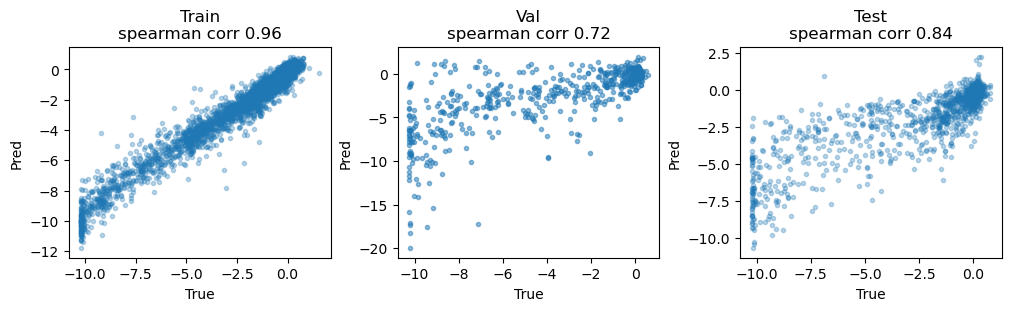

In [18]:
get_panel(df_embed, label='pred_ESMC600M_concat_ridge', omit=False, fit_label='fitness_raw') ## TEM1
# get_panel(df_embed, label='pred_ESMC600M_concat_ridge', omit=True, fit_label='fitness_log', omit_label='fitness_raw')  ## GB1

In [ ]:
# get_panel(df_zeroshot, label='pred_ESMC300M_masked_marginal', omit=False, fit_label='fitness_raw') ## TEM1
get_panel(df_zeroshot, label='pred_ESMC300M_masked_marginal', omit=True, fit_label='fitness_log', omit_label='fitness_raw')  ## GB1

In [ ]:
# get_panel(df_zeroshot, label='pred_ESMC300M_confit', omit=False, fit_label='fitness_raw') ## TEM1
get_panel(df_zeroshot, label='pred_ESMC300M_confit', omit=True, fit_label='fitness_log', omit_label='fitness_raw')  ## GB1

In [ ]:
def plot_comparison_corr_methods(df):
    ridge = defaultdict(list)
    rf    = defaultdict(list)
    mlp   = defaultdict(list)
    for idx in df.index:
        if not 'cls' in idx:
            if 'ridge' in idx:
                ridge['train'].append(df.loc[idx, 'train'])
                ridge['val'].append(df.loc[idx, 'val'])
                ridge['test'].append(df.loc[idx, 'test'])
            elif 'RF' in idx:
                rf['train'].append(df.loc[idx, 'train'])
                rf['val'].append(df.loc[idx, 'val'])
                rf['test'].append(df.loc[idx, 'test'])
            elif 'MLP' in idx:
                mlp['train'].append(df.loc[idx, 'train'])
                mlp['val'].append(df.loc[idx, 'val'])
                mlp['test'].append(df.loc[idx, 'test'])
            else:
                raise Exception('Huh?')
            
    def my_floor(a, precision=1):
        return np.round(a - 0.5 * 10**(-precision), precision)
            
    fig, ax = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')
    for i, dset in enumerate(['train', 'val', 'test']):
        # ax[i].hist(ridge[dset], label='ridge', alpha=0.8, 
        #            bins=np.arange(my_floor(np.nanmin(ridge[dset])),1.05,0.1))
        # ax[i].hist(rf[dset], label='rf', alpha=0.5,
        #            bins=np.arange(my_floor(np.nanmin(rf[dset])),1.05,0.1))
        # ax[i].hist(mlp[dset], label='mlp', alpha=0.3,
        #            bins=np.arange(my_floor(np.nanmin(mlp[dset])),1.05,0.1))
        
        _min = my_floor(np.nanmin(ridge[dset]+rf[dset]+mlp[dset]))
        ax[i].hist([ridge[dset], rf[dset], mlp[dset]], 
                   label=['linear', 'rf', 'mlp'], 
                   alpha=0.8, 
                   bins=np.arange(my_floor(_min),1.05,0.1))


        ax[i].legend()

    plt.show()


In [ ]:
plot_comparison_corr_methods(res_table_embed)